# 大雑把に過去を振り返ってみる
このドキュメントは、[ぴょこりんクラスタ Advent Calendar 2015](http://www.adventar.org/calendars/960)のために仕事から帰ったあと晩ご飯を食べながら書いたものです。

## 要約
* 流行りのデータ駆動型アプローチで今年1年を振り返った
* twitterにおけるつぶやく時間帯についての簡単なデータ分析を行った
* 雑な感じで変化点検出をしてみたら、お仕事に集中してtwitterを疎かにした日などが検出された
* お仕事に振り回されるシケた1年だった


## はじめに
　12月が始まってしまいました。思えば今年も色々ありました。ということでちょっとだけ今年を振り返ってみようかなと思います。とはいえ僕も睡眠時間やアニメを見る時間が大事なので、効率的に過去を振り返らなければなりません。あれもあったな、これもあったななどと一つ一つ思い出していくのは効率的ではありません。ここではデータ駆動型なアプローチでシステマティックかつイノベーティブな感じにちゃちゃっと今年を振り返ってみましょう。
 
## 扱うデータ
　さて、データ駆動型で今年を振り返るためには今年の僕の活動のログみたいなものが必要になります。残念ながら僕はセンサのようなものを持ち歩く癖は持ち合わせて無いので、ここでは僕のtwitterのつぶやきのログを用いることにします。twitterの設定の画面から全ツイート履歴をダウンロードすることができます。っつーわけでダウンロードしてどんな項目があるのかチェック。

In [39]:
import csv
tweets=[i for i in csv.reader(open('tweets.csv','rb'))]
tweets[0]

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls']

　さて、つぶやきを分析するとなればつぶやいたテキストに対して感情分析をかけて～なんてのがよくある流れかと思いますが、僕のつぶやきは大体ネガティブです。ここでは~~色々やってる時間がないので~~ツイートは投稿者の生活に即して行われるため、その時間帯はその生活に大きく影響してると考え、今回はtimestampだけ見ることにします。　　
## データの可視化
  ちゃちゃっと可視化してみましょう。この1年間どの時間帯によくつぶやいてたのか眺めてみます。

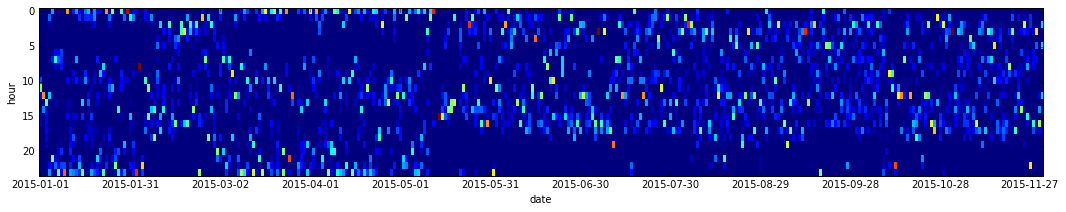

In [140]:
import datetime
import scipy as np
from matplotlib import pyplot
%matplotlib inline

timestamps=[datetime.datetime.strptime(i[3], "%Y-%m-%d %H:%M:%S +0000")+datetime.timedelta(hours=9) for i in tweets if i[0]!='tweet_id']
firststamp=min(timestamps)
firstday=datetime.datetime(firststamp.year,firststamp.month,firststamp.day)
day=(datetime.datetime(2015,1,1)-firstday).days
imax=(max(timestamps)-min(timestamps)).days+1
mat=np.zeros([24,imax])
for i in timestamps:
    mat[i.hour,(i-firstday).days]+=1
labels=[(i,firstday+datetime.timedelta(days=i)) for i in range(imax)]
tmp=mat.sum(0)
zeros=np.where(tmp==0)
tmp[zeros]=1
mat=mat/tmp[np.newaxis,:]
plt.figure(num=None, figsize=(18,3),dpi=80,facecolor='w',edgecolor='k')
plt.xlabel(u'date')
plt.ylabel(u'hour')
step=30
plt.xticks([i[0] for i in labels[:len(labels)-day+1:step]],[str(i[1]).split(' ')[0] for i in labels[day::step]])
plt.imshow(mat[:,day:], interpolation='nearest', aspect='auto')

　~~コードが汚い。~~縦軸が時間(日本時間)、横軸が日にちで、暗い青は1日の中でつぶやいてない時間帯、色が赤に近づくほど多くツイートしている時間帯を表しています。1月と3～5月中旬は午前1時～7時ごろが真っ青、この辺りは寝ていてつぶやいてないことがわかります。一方でそれ以外の期間は17～18時ごろから真っ青になっていて、明らかに違うタイムゾーンで生きている人みたいになっていることがわかります。
 
## 簡易変化点検出的な何か。
　日々つぶやく時間帯には一定の傾向がありそうなので、過去の数日と比較してつぶやく時間の傾向が大きく異なったとすれば、その日は何か非日常的なコトが起こったと言えそうです。ということでこの仮定に基づいてめっちゃ大雑把に変化点検出的なことをして、異常性の高い日を見つけましょう。

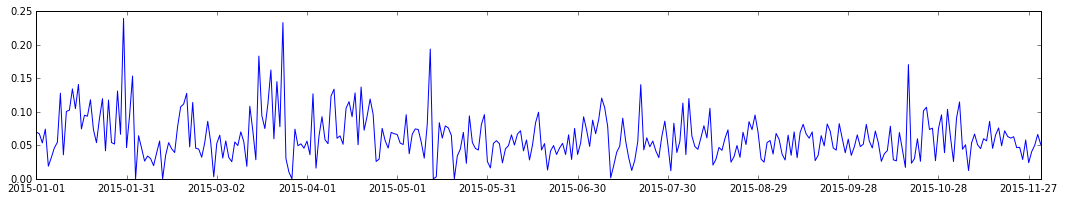

第1位: 2月3日 スコア：0.0
第2位: 2月12日 スコア：0.0
第3位: 3月27日 スコア：0.0
第4位: 5月13日 スコア：0.0
第5位: 5月20日 スコア：0.0
第6位: 7月11日 スコア：0.001443001443
第7位: 5月14日 スコア：0.00291545189504
第8位: 3月1日 スコア：0.00304532069238
第9位: 3月26日 スコア：0.0100204306145
第10位: 7月31日 スコア：0.0119951980792


In [154]:
a=np.array([np.dot(mat[:,i].T,np.mean(mat[:,i-7:i].T,axis=0)) for i in range(day,mat.shape[1])])

plt.figure(num=None, figsize=(18,3),dpi=80,facecolor='w',edgecolor='k')
plt.xticks([i[0] for i in labels[:len(labels)-day+1:step]],[str(i[1]).split(' ')[0] for i in labels[day::step]])
plt.plot(range(len(a)),a)
plt.show()
for j,i in enumerate(sorted(zip(list(a),labels[day:]))[:10]):
    print u'第'+str(j+1)+u'位: '+ str(i[1][1].month)+u'月'+ str(i[1][1].day)+u'日 スコア：'+str(i[0])

　ざっくりやってることを言えば過去一週間分の平均と内積を取ったものを類似度としただけです、高校数学です。ちょっぴり諸々気になる点がないわけでもないのですが、もう寝たいのでこのまま進めます。上のグラフは各日における過去一週間と比較した類似度のプロットです。縦軸が類似度のスコア（大きい方が似てる）、横軸が日にち。異常な日はこれが極端に少ないものとして現れてくれるはずです。ということでグラフの下にスコアが低いものベスト１０を列挙してみました。
## 考察 
 さてさて、列挙されたこれらの日は一体何があったのか、つぶやきを眺めてみることにします。ちなみにゴミ手法なので、つぶやいた回数が０の日はスコアが０になってしまいます。バグではなく仕様です。なので、たぶん1位から5位の日には僕は何もつぶやかなかったのだと思われます・・・っと思ったのですが、2/3は何かつぶやいてました。
<blockquote class="twitter-tweet" lang="ja"><p lang="ja" dir="ltr">完全に振り回されている...</p>&mdash; 人生凍結中 (@capp365) <a href="https://twitter.com/capp365/status/562388662826979328">2015年 2月 3日</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>
　思い出せない、何に振り回されてたっけこの時期・・・。たぶんお仕事なのは間違いありません。続けて他の日も見てみましょう。6位の7/11はこんなツイートをしていました。
 <blockquote class="twitter-tweet" lang="ja"><p lang="ja" dir="ltr">ＴＬから土曜の香りが漂い始め、帰りたくなってきました。</p>&mdash; 人生凍結中 (@capp365) <a href="https://twitter.com/capp365/status/619672250623504384">2015年 7月 11日</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>
上述のツイートはこの日最初のもの、このツイートの時点でもう夕方なので、この日は業務時間中にほとんどtwitterをやってなかったようです。集中して仕事した日が異常な日として扱われてるってわけ。執筆者の就労への姿勢が伺えます。次は5/14。
<blockquote class="twitter-tweet" lang="ja"><p lang="ja" dir="ltr">@各位 生きてます。</p>&mdash; 人生凍結中 (@capp365) <a href="https://twitter.com/capp365/status/598732038368165888">2015年 5月 14日</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>
渡米したちょっとあとのタイミング。生存報告をしています。次、3/1。
<blockquote class="twitter-tweet" lang="ja"><p lang="ja" dir="ltr">日本最高だな。ひだまりスケッチ新刊売ってる</p>&mdash; 人生凍結中 (@capp365) <a href="https://twitter.com/capp365/status/571862454172446720">2015年 3月 1日</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>
どう見ても長期出張帰国直後です本当にありがとうございました。次、3/26。
<blockquote class="twitter-tweet" lang="ja"><p lang="ja" dir="ltr">午前中にお休みをいただいて圧倒的成長だよ！</p>&mdash; 人生凍結中 (@capp365) <a href="https://twitter.com/capp365/status/580930786276184064">2015年 3月 26日</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>
午前半休をとった日が異常扱いされるってのもなかなかアレですね。
<blockquote class="twitter-tweet" lang="ja"><p lang="ja" dir="ltr">打ち合わせ、4人以上になるともはや意味をなさないのでは。</p>&mdash; 人生凍結中 (@capp365) <a href="https://twitter.com/capp365/status/626832317856661504">2015年 7月 30日</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>
午前中に4人以上の参加者がいる打ち合わせがあったみたいです。もちろんその間はつぶやくことが出来ず、異常な日だと扱われたのかなと思います。というわけで異常な日は大体業務に関連して起きているみたいです。僕の日常は業務に振り回されている。シケた人生だったね。

## まとめ
  データ駆動型のアプローチで雑な感じに今年を振り返ってみた。結果、社会に振り回されていることがわかった。業務がなくなれば平穏な日常が帰ってくるかもしれないけど、生きるためにそれはまだちょっと難しいので今後の課題とするよ。